# X-Ray Detector Calibration

Ce notebook présente des propositions de solutions au challenge 
[Soleil](https://www.codabench.org/competitions/12117/), proposé dans le cadre du Datacamp 2025 de l’Institut Polytechnique.

L’objectif du challenge est de prédire l’abscisse du point d’inflexion d’une courbe bruitée.  
Cette courbe est utilisée pour la calibration d’un détecteur de rayons X.

Le principal enjeu consiste à concevoir un modèle capable de généraliser de manière robuste.  
L’évaluation, basée sur la métrique MSE (Mean Squared Error), est réalisée sur un jeu de données dont les courbes appartiennent à un domaine différent de celui des données d’entraînement.

Ces différents domaines correspondent à des niveaux énergétiques distincts du rayon incident sur le capteur lors de la phase de calibration.

Des informations complémentaires concernant l’origine des données et leur nature sont disponibles sur la page Codabench du challenge.

L’une des difficultés majeures est qu’il s’agit en réalité d’un problème de transfer learning, et plus précisément de covariate shift.
L’entraînement est effectué sur une distribution correspondant à deux niveaux d’énergie, tandis que l’évaluation est réalisée sur une distribution associée à un autre niveau d’énergie.


## Visualisation des données

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tsfresh import extract_relevant_features

In [2]:
num_cores = os.cpu_count()
print(num_cores)

input_dir = 'data/dev_phase/input_data'
reference_dir = 'data/dev_phase/reference_data'

8


In [3]:
def get_data():
    """ Get X_train, y_train, X_adapt and X_test from csv files
    """
    # Read datad/reference
    X_train = pd.read_csv(os.path.join(input_dir, 'train.csv'), header=None)
    y_train = pd.read_csv(os.path.join(input_dir, 'train_labels.csv'), header=None)
    X_adapt = pd.read_csv(os.path.join(input_dir, 'train_DA.csv'), header=None)
    X_test = pd.read_csv(os.path.join(input_dir, 'test.csv'), header=None)
    y_test = pd.read_csv(os.path.join(reference_dir, 'test_labels.csv'), header=None)

    return X_train, y_train, X_adapt, X_test, y_test

In [4]:
X_train, y_train, X_adapt, X_test, y_test = get_data()

In [5]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,421.0,7.0,10.0,7.0,8.0,10.0,7.0,9.0,11.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,411.0,2.0,5.0,7.0,5.0,5.0,2.0,6.0,8.0,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,411.0,6.0,2.0,6.0,9.0,7.0,5.0,8.0,1.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,414.0,7.0,6.0,4.0,5.0,2.0,4.0,3.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1644.0,1106.0,1174.0,1215.0,1198.0,1097.0,1146.0,1104.0,1114.0,1127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65443,407.0,3.0,3.0,5.0,8.0,7.0,4.0,7.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65444,412.0,5.0,5.0,6.0,7.0,5.0,3.0,7.0,4.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65445,410.0,4.0,3.0,5.0,3.0,3.0,2.0,7.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65446,409.0,4.0,5.0,2.0,6.0,5.0,7.0,14.0,6.0,6.0,...,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [6]:
y_train

,0
0,228.0
1,230.0
2,223.0
3,228.0
4,159.0
...,...
65443,221.0
65444,231.0
65445,234.0
65446,250.0


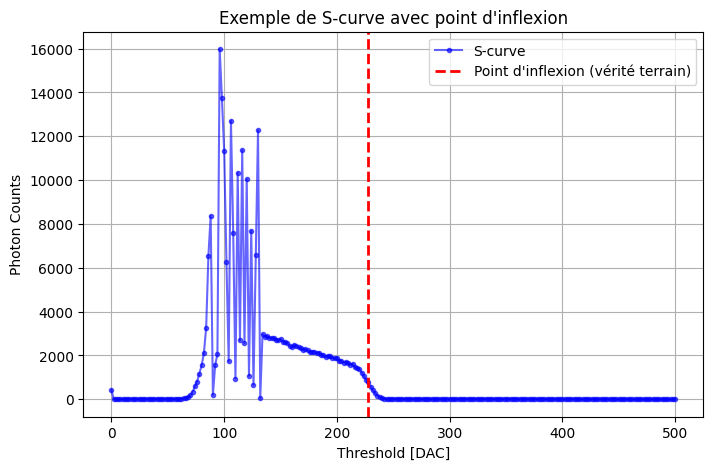

In [12]:
idx = 0  # indice de la courbe à afficher

thr_vector = np.arange(0, 501, 2)  # Threshold scan (DAC)
s_curve = X_train.iloc[idx, :]
true_inflexion = y_train.iloc[idx, 0]



plt.figure(figsize=(8, 5))

# Courbe S
plt.plot(
    thr_vector,
    s_curve,
    marker='o',
    markersize=3,
    color='b',
    alpha=0.6,
    label="S-curve"
)

# Barre verticale du point d'inflexion
plt.axvline(
    x=true_inflexion,
    color='r',
    linestyle='--',
    linewidth=2,
    label="Point d'inflexion (vérité terrain)"
)

plt.title("Exemple de S-curve avec point d'inflexion")
plt.xlabel("Threshold [DAC]")
plt.ylabel("Photon Counts")
plt.legend()
plt.grid(True)
plt.show()


## 1 – Première approche : analyse de la courbe

L’objectif étant de régresser l’abscisse du point d’inflexion de la courbe, il est naturel de revenir à sa définition mathématique.  
Un point d’inflexion correspond à une abscisse pour laquelle la dérivée seconde s’annule.

Cependant, en raison du bruit présent dans les courbes, cette approche directe s’avère peu robuste : de nombreux points présentent une dérivée seconde proche de zéro. En revanche, la recherche du minimum de la dérivée permet d’identifier de manière plus fiable le point d’inflexion recherché.

Toutefois, les variations de grande amplitude observées au début du signal perturbent fortement cette analyse. Afin de limiter cet effet, la méthode proposée consiste à tronquer la courbe afin d’ignorer cette partie non pertinente.

La méthode développée est donc la suivante :

1. **Rééchantillonnage** de la courbe avec un pas de 1 (contre un pas de 2 dans les données originales).
2. **Détection d’un seuil** permettant d’identifier la partie « intéressante » de la courbe :  
   le signal est parcouru dans le sens inverse, et le parcours est interrompu dès qu’un saut de valeur supérieur à un seuil fixé est observé pour la première fois.  
   À ce stade, un recul virtuel est appliqué en ajoutant une marge de sécurité, elle aussi déterminée empiriquement.
3. **Lissage** de la courbe tronquée.
4. **Calcul de la dérivée** du signal lissé.
5. **Ajustement polynomial** autour du minimum de la dérivée afin de réduire davantage l’effet du bruit.  
   L’abscisse du minimum est alors estimée à partir des paramètres du polynôme ajusté.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10800\3541143107.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  inf = int(y_test.iloc[example_idx])         # point de référence


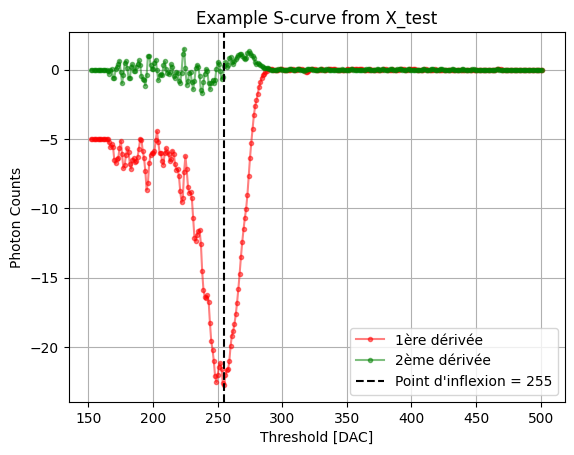

Point d'inflexion calculé : 255.0


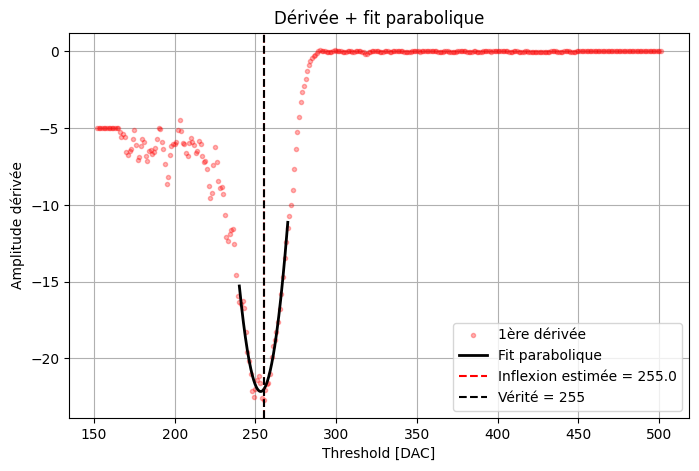

In [ ]:
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from skimage.restoration import denoise_tv_chambolle

example_idx = 11978    
seuil = 76
step = 2  # échantillonnage tous les 2 DAC
new_step =1
s_curve = X_test.iloc[example_idx][seuil:]  # S-curve à partir du seuil
inf = int(y_test.iloc[example_idx])         # point de référence

# Axe DAC original
x_orig = np.arange(seuil*step, seuil*step + len(s_curve)*step, step)

# Nouvel axe DAC avec pas = 1
x_new = np.arange(seuil*step, seuil*step + len(s_curve)*step, new_step)

# Interpolation linéaire
s_curve_resampled = np.interp(x_new, x_orig, s_curve)

# Lissage
features_smooth = savgol_filter(s_curve_resampled, window_length=29, polyorder=1)

# Dérivées
d = np.gradient(features_smooth,new_step)
d2 = np.gradient(d,new_step)

# # Plot
plt.figure()   
plt.plot(x_new, d, marker='o', markersize=3, color='red', alpha=0.5, label='1ère dérivée')
plt.plot(x_new, d2, marker='o', markersize=3, color='green', alpha=0.5, label='2ème dérivée')
plt.axvline(x=inf, color='black', linestyle='--', label=f'Point d\'inflexion = {inf}')
plt.title("Example S-curve from X_test")
plt.xlabel("Threshold [DAC]")
plt.ylabel("Photon Counts")
plt.grid(True)
plt.legend()
plt.show()

# Calcul du point d'inflexion avec min
i0 = np.argmin(d)
w = 15
idx = np.arange(i0 - w, i0 + w + 1)
idx = idx[(idx >= 0) & (idx < len(d))]

a, b, c = np.polyfit(x_new[idx], d[idx], 2)
x_inflection = -b / (2*a)
x_inflection = np.ceil(x_inflection)+1
print("Point d'inflexion calculé :", x_inflection)

# Courbe de la parabole ajustée
x_fit = np.linspace(x_new[idx].min(), x_new[idx].max(), 200)
y_fit = a * x_fit**2 + b * x_fit + c

plt.figure(figsize=(8,5))

# Dérivées
plt.plot(x_new, d, '.', color='red', alpha=0.3, label='1ère dérivée')

# Fit parabolique local
plt.plot(x_fit, y_fit, 'k-', lw=2, label='Fit parabolique')

# Point d'inflexion estimé
plt.axvline(x_inflection, color='red', linestyle='--',
            label=f'Inflexion estimée = {x_inflection}')

# Vérité terrain
plt.axvline(x=inf, color='black', linestyle='--',
            label=f'Vérité = {inf}')

plt.title("Dérivée + fit parabolique")
plt.xlabel("Threshold [DAC]")
plt.ylabel("Amplitude dérivée")
plt.grid(True)
plt.legend()
plt.show()


*NB: L'ajustement polynomial est criticable. Dans certains cas il améliore la prédiction dans d'autres il l'améliore. De manière empirique il a été déterminé que cet ajustement est bénéfique.*

In [15]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error

def compute_inflection_points_with_errors(X, y_true, seuil_defaut=100, step=2, new_step=1, w=15, window_savgol=29, poly_savgol=1):
    """
    Calcule le point d'inflexion pour chaque S-curve du dataset.
    """
    n_samples = X.shape[0]
    y_pred = np.zeros(n_samples)
    seuils_list = np.zeros(n_samples)
    
    for i in range(n_samples):
        seuil = seuil_defaut
        s_curve = X[i, :]

        # Calcul du seuil
        for ind in range(1,len(s_curve)-1):
            if np.abs(s_curve[-ind-1] - s_curve[-ind]) > 60:
                seuil = ((len(s_curve) - ind ) + 60)//2
                seuil = seuil
                break
        seuils_list[i] = seuil
        s_curve = X[i, seuil:]

        # Axe DAC original et rééchantillonné
        x_orig = np.arange(seuil*step, seuil*step + len(s_curve)*step, step)
        x_new = np.arange(seuil*step, seuil*step + len(s_curve)*step, new_step)
        
        s_curve_resampled = np.interp(x_new, x_orig, s_curve)
        features_smooth = savgol_filter(s_curve_resampled, window_length=window_savgol, polyorder=poly_savgol)
        d = np.gradient(features_smooth, new_step)
        
        i0 = np.argmin(d)
        idx = np.arange(i0 - w, i0 + w + 1)
        idx = idx[(idx >= 0) & (idx < len(d))]
        
        a, b, c = np.polyfit(x_new[idx], d[idx], 2)
        if np.abs(a) < 1e-12:
            x_inflection = x_new[i0]
        else:
            x_inflection = -b / (2*a)
        
        x_inflection = np.ceil(x_inflection) + 1
        y_pred[i] = x_inflection
    

    mse = mean_squared_error(y_true, y_pred)
    
    return y_pred, mse

# Exemple d'utilisation
y_true = y_test.to_numpy().flatten()
X_np = X_test.to_numpy()

y_pred, mse = compute_inflection_points_with_errors(X_np, y_true)

print("Mean Squared Error:", mse)



Mean Squared Error: 0.9183766927622827


---
Au vu des résultats obtenus sur le jeu de test, le modèle semble très performant. Toutefois, de nombreux seuils sont en pratique choisis de manière arbitraire. Lorsque l’on observe les performances du modèle sur le jeu d’entraînement, celles-ci s’avèrent nettement moins bonnes (MSE ≈ 13). On constate alors que ces paramètres jouent un rôle crucial et qu’ils ont ici été ajustés pour correspondre au jeu de test, ce qui constitue une forme de fuite de données.

Il serait possible d’affiner cette méthode afin d’obtenir un modèle plus généralisable ; néanmoins, la suite de notre approche s’oriente vers des solutions sensiblement différentes.

---


## 2 – Seconde approche : une méthode de Deep Learning

Une approche plus ambitieuse consiste à recourir à des méthodes de Deep Learning.  
Au vu de la nature séquentielle des données, l’utilisation d’un réseau de neurones récurrent (RNN) apparaît comme un choix pertinent.

Par ailleurs, compte tenu de la structure locale associée à un point d’inflexion, un RNN bidirectionnel semble particulièrement adapté pour capturer les dépendances à la fois passées et futures du signal.

Après plusieurs expérimentations et ajustements de l’architecture, le modèle présenté ci-dessous est celui ayant permis d’obtenir les meilleures performances en termes de généralisation.

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader,Dataset,random_split

import time
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

In [ ]:
from pathlib import Path
from IPython.display import display, HTML
from torch.utils.tensorboard import SummaryWriter

TB_PATH = "/tmp/logs/Test"

%load_ext tensorboard
%tensorboard --logdir {TB_PATH}

# # TENSORBOARD V2 (outside notebook => Navigateur)
# # usage externe de tensorboard: (1) lancer la commande dans une console; (2) copier-coller l'URL dans un navigateur
# display(HTML("<h2>Informations</h2><div>Pour visualiser les logs, tapez la commande : </div>"))
# print(f"tensorboard --logdir {Path(TB_PATH).absolute()}")
# print("Une fois la commande lancer dans la console, copier-coller l'URL dans votre navigateur")


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.signal import savgol_filter
import numpy as np
from scipy.signal import savgol_filter


class Transform:
    def __init__(
        self,
        smooth_window=11,
        polyorder=1
    ):
        self.smooth_window = smooth_window
        self.polyorder = polyorder

    def __call__(self, serie):
        serie = np.asarray(serie, dtype=np.float32).squeeze()
        L = len(serie)

        x_ori = np.arange(0,L*2,2)
        x_new = np.arange(0,L*2,1)

        signal_raw = np.interp(x_new, x_ori, serie)

        window = self.smooth_window
        if window >= len(signal_raw):
            window = len(signal_raw) - 1
        if window % 2 == 0:
            window += 1

        signal_smooth = savgol_filter(
            signal_raw,
            window_length=window,
            polyorder=self.polyorder
        )


        d1 = np.gradient(signal_smooth, 1)

        d2 = np.gradient(d1, 1)

        return np.stack(
            [signal_raw, signal_smooth, d1, d2],
            axis=0
        )



Bien que les convolutions soit théoriquement capable d'extraires les dérivés on aide le modèle en lui fournissant dès l'entrée les dérivés premières et seconde ainsi qu'une courbe grosssièrement lissé.

In [ ]:
class SeriesDataset(Dataset):
    def __init__(self, features_csv, targets_csv, transform=None):
        # Charger depuis disque UNE FOIS
        self.features = pd.read_csv(features_csv).values
        self.targets = pd.read_csv(targets_csv).values.squeeze()

        # Normalisation
        scaler = TimeSeriesScalerMeanVariance()
        self.features = scaler.fit_transform(self.features)

        self.transform = transform

        if self.transform:
            X = []
            for serie in self.features:
                X.append(self.transform(serie))
            # (n_series, 3, seq_len*2)
            self.features = torch.tensor(
                np.stack(X), dtype=torch.float32
            )
        else:
            self.features = torch.tensor(
                self.features, dtype=torch.float32
            ).unsqueeze(1)

        self.targets = torch.tensor(
            self.targets, dtype=torch.float32
        )

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [ ]:
data_transform = Transform()

train_dataset = SeriesDataset(input_dir+"/train.csv", input_dir+"/train_labels.csv", transform=data_transform)
test_dataset = SeriesDataset(input_dir+"/test.csv", reference_dir+"/test_labels.csv", transform=data_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
for x_batch, y_batch in train_loader:
    print(f"Shape of features (x_batch): {x_batch.shape}")
    print(f"Shape of targets (y_batch): {y_batch.shape}")
    break

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

def train(model, epochs, train_loader, test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}")
    max_lr = 1e-2
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs * len(train_loader),
        eta_min=1e-6
    )

    model = model.to(device)
    print(f"running {model.name}")

    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()

    for epoch in tqdm(range(epochs)):
        model.train()
        train_cumloss, count = 0, 0

        for x, y in train_loader:
            x, y = x.to(device) , y.to(device)
            ylong = y.to(device).long()
            optimizer.zero_grad()
            scores, abs = model(x)
            loss = ce_loss(scores, ylong) + 0.01*mse_loss(abs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_cumloss += loss.item() * len(x)
            count += len(x)
        writer.add_scalar('loss/train', train_cumloss / count, epoch)

        model.eval()
        mse_sum, count = 0.0, 0

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                scores, _ = model(x)
                t_pred = torch.argmax(scores, dim=1)
                loss = mse_loss(t_pred, y)
                mse_sum += loss.item() * len(x)
                count += len(x)

        mse = mse_sum / count
        writer.add_scalar('mse/test', mse, epoch)


In [ ]:
class ConvBiLSTMA(nn.Module):
    def __init__(self, input_size, hidden_size, conv_channels=32, kernel_size=5):
        super().__init__()

        padding = kernel_size // 2
        # Conv
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_size, conv_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),

            nn.Conv1d(conv_channels, conv_channels, kernel_size, padding=padding),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU(),
        )
        
        # BiLSTM
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True,
            num_layers=3,
            dropout=0.3
        )

        # Attention scorer 
        self.scorer = nn.Linear(hidden_size * 2, 1)

        #self.norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        # x : (batch, seq_len, input_size)

        # Conv1D attend (batch, channels, seq_len)
        x = self.conv_block(x)
        x = x.transpose(1, 2)  # back to (batch, seq_len, channels)

        # BiLSTM
        h, _ = self.lstm(x)

        # Layer Norm
        h = self.norm(h)

        # Attention scores
        scores = self.scorer(h).squeeze(-1)  # (batch, seq_len)

        # Soft-argmax (train)
        probs = torch.softmax(scores, dim=1)
        t = torch.arange(scores.size(1), device=scores.device)
        abscisse_soft = torch.sum(probs * t, dim=1)

        return scores, abscisse_soft


In [ ]:
model = ConvBiLSTMA(input_size= 4,
               hidden_size= 128,
               conv_channels=64).to(device)
model.name="Convbi-RNN-"+time.asctime().replace(":","-")

epochs= 50

In [ ]:
train(model,epochs,train_loader,test_loader)

---

Les résultats obtenus sont très satisfaisants : une MSE proche de 0,1 est observée sur le jeu d’entraînement, tandis qu’elle atteint environ 0,3 sur le jeu de test. Ces performances indiquent une bonne capacité de généralisation du modèle.

Toutefois, le gain par rapport à la première approche reste limité. Il est donc légitime de s’interroger sur l’intérêt d’un tel modèle, dont la complexité et le coût computationnel sont significativement plus élevés.

---


## 3 – Troisième approche : une méthode hybride

La première approche se distinguait par sa simplicité et sa forte explicabilité, puisqu’elle reposait directement sur des principes mathématiques. Il serait donc regrettable de l’abandonner entièrement. Une alternative consiste alors à concevoir une méthode hybride, combinant cette approche analytique avec un modèle d’apprentissage.

L’idée est d’utiliser un réseau de neurones pour estimer, de manière adaptative, un seuil propre à chaque courbe. Ce seuil permettrait ensuite d’appliquer les étapes analytiques classiques : lissage du signal, calcul de la dérivée et recherche du minimum. Un tel modèle serait, a priori, particulièrement performant.

Toutefois, la principale difficulté réside dans la capacité à encoder de manière différentiable des opérations initialement discrètes, telles que le calcul de la dérivée, la recherche de l’argmin ou encore certaines opérations de lissage.

Le modèle présenté ci-dessous vise à répondre à cette problématique. Néanmoins, il introduit plusieurs goulots d’étranglement qui rendent son utilisation plus complexe que prévu. Un phénomène de *collapse* du modèle vers une prédiction moyenne est notamment observé de manière récurrente. En pratique, l’obtention d’un réglage satisfaisant s’avère délicate. Malgré ces limitations, cette approche propose une alternative originale, que nous considérons comme élégante et ingénieuse, et qu’il nous semble pertinent de présenter.


In [ ]:
class SoftCrop1D(nn.Module):
    def __init__(self, sharpness=5.0):
        super().__init__()
        self.sharpness = sharpness

    def forward(self, x, tau):
        # x : (B, C, L)
        B, C, L = x.shape
        t = torch.arange(L, device=x.device).float()
        mask = torch.sigmoid((t[None, :] - tau[:, None]) / self.sharpness)
        return x * mask[:, None, :]

In [ ]:
class GaussianSmoothing(nn.Module):
    def __init__(self, kernel_size=11, sigma=2.0):
        super().__init__()

        self.kernel_size = kernel_size
        self.sigma = sigma

        # noyau gaussien fixe (1, 1, k)
        t = torch.arange(kernel_size).float() - kernel_size // 2
        kernel = torch.exp(-t**2 / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        self.register_buffer("kernel", kernel.view(1, 1, kernel_size))

    def forward(self, x):

        return F.conv1d(
            x,
            self.kernel,
            padding=self.kernel_size // 2
        )


In [ ]:
class Grad(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = torch.tensor([-0.5, 0.0, 0.5], dtype=torch.float32)
        self.register_buffer("kernel", kernel.view(1, 1, 3))

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)

        dx = F.conv1d(
            x,
            self.kernel,
            padding=1
        )

        return dx.squeeze(1) if dx.size(1) == 1 else dx


In [ ]:
def soft_argmin(x, temperature=0.01):
    B, L = x.shape
    t = torch.arange(L, device=x.device, dtype=x.dtype)

    logits = -x / temperature
    probs = torch.softmax(logits, dim=1)
    tau = torch.sum(probs * t, dim=1)

    return tau, probs


*NB : Des essais ont également été menés en cherchant à prédire le paramètre σ du filtre gaussien ainsi que la température du soft-argmin. Toutefois, ces choix introduisent un nombre trop important de degrés de liberté, ce qui conduit le modèle à un phénomène de collapse, avec une tendance systématique à prédire la valeur moyenne du label.*


In [ ]:
class BiConvBiLSTMA(nn.Module):
    def __init__(self,input_size, hidden_size,
                 conv1_channels=32, conv2_channels=32,
                 conv3_channels=32, conv4_channels=32,
                 reductor1_channels=16*2, reductor2_channels=8,
                 hidden_linear=32, conv_kernel_size=5):
        super().__init__()

        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=conv1_channels,
            kernel_size=conv_kernel_size,
            padding=conv_kernel_size // 2
        )

        self.conv2 = nn.Conv1d(
            in_channels=conv1_channels,
            out_channels=conv2_channels,
            kernel_size=conv_kernel_size,
            padding=conv_kernel_size // 2
        )

        self.conv3 = nn.Conv1d(
            in_channels=conv2_channels,
            out_channels=conv3_channels,
            kernel_size=conv_kernel_size,
            padding=conv_kernel_size // 2
        )

        self.conv4 = nn.Conv1d(
            in_channels=conv3_channels,
            out_channels=conv4_channels,
            kernel_size=conv_kernel_size,
            padding=conv_kernel_size // 2
        )

        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(
            input_size=conv2_channels,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )

        self.reductor1 = nn.Conv1d(
            in_channels=hidden_size*2,
            out_channels=reductor1_channels,
            kernel_size=conv_kernel_size,
            stride=4,
            padding=conv_kernel_size // 2
        )

        self.reductor2 = nn.Conv1d(
            in_channels=reductor1_channels,
            out_channels=reductor2_channels,
            kernel_size=conv_kernel_size,
            stride=4,
            padding=conv_kernel_size // 2
        )

        self.attention = AttentionPooling(reductor2_channels)

        self._tau = nn.Sequential(
            nn.Linear(reductor2_channels, hidden_linear),
            nn.ReLU(),
            nn.Linear(hidden_linear,1)
        )

        self._sigma = nn.Sequential(
            nn.Linear(reductor2_channels, hidden_linear),
            nn.ReLU(),
            nn.Linear(hidden_linear,1)
        )

        self._temp = nn.Sequential(
            nn.Linear(reductor2_channels, hidden_linear),
            nn.ReLU(),
            nn.Linear(hidden_linear,1)
        )

    def forward(self, x):

        # Conv
        #x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = x.transpose(1, 2)

        # BiLSTM
        h, _ = self.lstm(x)

        # Reduction
        h = h.transpose(1, 2)
        h = self.relu(self.reductor1(h))
        h = self.relu(self.reductor2(h))

        # Attention pooling
        h = h.transpose(1, 2)
        h = self.attention(h)

        # Linear
        tau = self._tau(h)
        sigma = self._sigma(h)
        temp = self._temp(h)

        tau = tau.squeeze(1)
        sigma = sigma.squeeze(1)
        temp = temp.squeeze(1)

        return tau, sigma, temp

In [ ]:
class MyModel(nn.Module):
    def __init__(
        self,
        input_size=1,
        hidden_size=32,
        conv1_channels=32,
        conv2_channels=32,
        conv3_channels=32,
        conv4_channels=32,
        hidden_linear=32,
        conv_kernel_size=5,
        Gaussian_kernel_size=31,
        sharpness=5.0,
    ):
        super().__init__()

        self.backbone = BiConvBiLSTMA(
            input_size=input_size,
            hidden_size=hidden_size,
            conv1_channels=conv1_channels,
            conv2_channels=conv2_channels,
            conv3_channels=conv3_channels,
            conv4_channels=conv4_channels,
            hidden_linear=hidden_linear,
            conv_kernel_size=conv_kernel_size,
        )

        self.crop = SoftCrop1D(sharpness=sharpness)
        self.smoother = GaussianSmoothing(Gaussian_kernel_size)

        self.grad = Grad()

    def forward(self, x):
        """
        x : (B, C, L)
        """

        B, C, L = x.shape

        # Backbone
        tau, sigma, temp = self.backbone(x)

        # Clamping
        sigma = F.softplus(sigma) + 1e-3
        sigma = sigma.clamp(max=self.smoother.kernel_size / 2)

        temp = F.softplus(temp) + 1e-5
        temp = temp.clamp(max=0.1)

        tau = tau.clamp(min=0, max=L - 1)
        tau_raw = tau
        tau = (L - 1) * torch.sigmoid(tau_raw)


        # Croping
        x_to_crop =  x[:, 0:1, :]
        x_crop = self.crop(x_to_crop, tau)

        # Smooting
        x_smooth = self.smoother(x_crop)

        # Gradient
        x_dif = self.grad(x_smooth)

        # Argmin
        y, probs = soft_argmin(x_dif)

        return y, probs


In [ ]:
model = MyModel(input_size=4).to(device)
model.name="ExpertModel-"+time.asctime().replace(":","-")

epochs= 50

In [ ]:
train(model, epochs, train_loader, test_loader)

Malgré de nombreux essais — changements de fonction de perte, d’hyperparamètres et même d’architecture du modèle — les performances en généralisation restent globalement médiocres.

Le problème d’optimisation ne présente pas un minimum unique : il est possible de découper (cropper) la courbe à différents instants tout en obtenant une erreur nulle. Cette multiplicité de solutions rend la convergence vers une solution réellement pertinente difficile.

Les bonnes performances observées sur le jeu de test seraient ainsi principalement dues à un phénomène de surapprentissage.


*NB :* Dans ce travail, les performances sur le jeu de test sont explicitement visualisées.  
Dans un cadre rigoureux de *transfer learning*, une telle pratique doit être maniée avec précaution, car l’ajustement des hyperparamètres en fonction de la distribution cible compromettrait l’objectif même du transfert, en introduisant un biais méthodologique.

Nous faisons ici l’hypothèse que cette adaptation implicite est restée limitée. Néanmoins, ce point constitue un risque expérimental qu’il convient de souligner.  
La seconde phase du défi Codabench, qui introduira de nouvelles distributions cibles, permettra d’évaluer de manière plus fiable la capacité réelle de généralisation des approches proposées et de détecter d’éventuels phénomènes de *data leakage* induits par le protocole expérimental.
